In [542]:
import pymongo
from pymongo import MongoClient
import pandas as pd
import numpy as np
import re
import itertools

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import Normalizer

from scipy.sparse.linalg import norm

%matplotlib inline
import matplotlib.pyplot as plt

from df_builder_mini_cleaner import *

# Creating the DataFrame

In [2]:
cnn_df = pd.read_csv('data/cnn.csv')
fox_df = pd.read_csv('data/fox.csv')
onion_df = pd.read_csv('data/onion_csv.csv')

In [3]:
df_final = build_df(onion_df, fox_df, cnn_df)

In [5]:
df_final

,Article,Satire,CNN,Fox
0,washington in a statement confirming his suppo...,1,0,0
1,washington irked that the attorney general’s b...,1,0,0
2,stamford ct lamenting that the numbers were mu...,1,0,0
3,nairobi kenya warning that a complete overhaul...,1,0,0
4,napa ca after being lovingly tended by generat...,1,0,0
5,pineville la citing concerns over historically...,1,0,0
6,cambridge ma warning that nothing was more dan...,1,0,0
7,south bend in stumbling through the restaurant...,1,0,0
8,heaven speaking with obvious nostalgia regardi...,1,0,0
9,cary nc competing to secure the new pet’s alle...,1,0,0


### More Cleaning

In [403]:
def new_cleaner(df):
    '''
    Removes more features like punctuation and words that
    should not be in there
    Input: df_final
    output: df_final with cleaned articles
    '''
    article_list = list(df_final.Article)
    clean_list = []
    for article in article_list:
        samp1 = re.sub('[''\”\“\‘;—:\'\'\'•·%$!&+}{|><_]', '', article)
        samp2 = samp1.replace('news','')
        clean_list.append(samp2.replace('fox',''))
    df['Article'] = clean_list
    return df

In [404]:
new_df_final = new_cleaner(df_final)

In [405]:
new_df_final.Article[0]

'washington in a statement confirming his support of the recent us supreme court decision on lethal injection and the eighth amendment associate justice brett kavanaugh reiterated his belief monday that cruel and unusual punishment was what makes someone a true kappa the amendments to the constitution are full of nuance and it’s time the court acknowledged that actions so often classified as cruel and unusual punishment’ are actually vital in helping young guys claim their spot in the kappa brotherhood said kavanaugh who cited his personal experience in rushing a fraternity and the vital role severe pain terror and shame played in thoroughly vetting the ideal delta kappa epsilon member if you’re creating a frat brother from scratch you want a guy who can inflict excessive suffering in a worthless piece of shit pledge who drinks like a little bitch without subjecting a pledge to excessive pain and suffering there’s no way for the rest of the frat to know who can handle their shit and wh

# Word Count

In [29]:
def word_count(content_list):
    '''
    Takes in a list of fox articles that is a list of strings
    and then returns an average word count for each article.
    input: list of strings
    output: average word count per article
    '''
    
    count = 0
    words = 0
    
    
    # Come back for more preprocessing
    # Right now this is just a rough estimate
    # because the numbers in the articles are messing up
    # the count
    # (), "" are also messing up the count
    for x in content_list:
        length = len(x.split()) 
        words += length
        count += 1
    print(count)
    print(words)
    print(words/count)
    return words/count

In [30]:
onion_word_count = word_count(list(df_final.Article[0:5000]))

5000
913827
182.7654


In [34]:
cnn_word_count = word_count(list(df_final.Article[5000:10000]))

5000
3691602
738.3204


In [40]:
fox_word_count = word_count(list(df_final.Article[10000:]))

4354
2273203
522.0953146531924


In [45]:
word_counts_df = pd.DataFrame([['Onion', onion_word_count], ['CNN', cnn_word_count], ['Fox', fox_word_count]], columns=['Source', 'Average_Word_Count'])

Text(0.5, 0, 'Source')

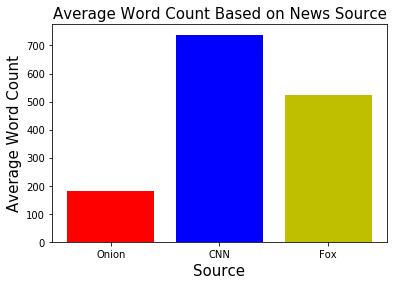

In [48]:
fig, ax = plt.subplots()
plt.bar(word_counts_df.Source.values,word_counts_df.Average_Word_Count, color ='rby')
ax.set_title("Average Word Count Based on News Source", fontsize = 15)
ax.set_ylabel("Average Word Count", fontsize = 15)
ax.set_xlabel("Source", fontsize = 15)

# Models

### Tokenizing and Stemming

In [406]:
porter = PorterStemmer()

In [407]:
def tokenize(doc):
    return [porter.stem(word) for word in word_tokenize(doc)]

### Train Test Split

In [408]:
docs_train, docs_test, y_train, y_test = train_test_split(new_df_final['Article'], new_df_final['Satire'])

### TFIDF Vectorization 

In [409]:
vect = TfidfVectorizer(stop_words='english', tokenizer=tokenize, min_df=3)
X_train = vect.fit_transform(docs_train)
X_test = vect.transform(docs_test)

/Users/jphooster22/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_

### Normalize

In [177]:
# norm = Normalizer()
# X_train = norm.fit_transform(X_train_vect)
# X_test = norm.transform(X_test_vect)

In [181]:
# X_train[0].sum(), X_train[1].sum()

(8.533406894297245, 8.203321162396602)

### Logistic Regression Model

In [410]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

/Users/jphooster22/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [411]:
log_reg_y_pred = log_reg.predict(X_test)
log_reg_con_mat = confusion_matrix(y_test, log_reg_y_pred)
recall_log_reg = log_reg_con_mat[1,1]/(log_reg_con_mat[1,1]+log_reg_con_mat[1,0])
prec_log_reg = log_reg_con_mat[1,1]/(log_reg_con_mat[1,1]+log_reg_con_mat[0,1])
F1_log_reg = ((prec_log_reg*recall_log_reg)/(prec_log_reg+recall_log_reg))*2
F1_log_reg

0.9733870967741935

### Naive Bayes Model

In [412]:
na_ba = MultinomialNB(alpha=.1)
na_ba.fit(X_train, y_train)



MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [413]:
na_ba_pred = na_ba.predict(X_test)
na_ba_con_mat = confusion_matrix(y_test, na_ba_pred)
recall_na_ba= na_ba_con_mat[1,1]/(na_ba_con_mat[1,1]+na_ba_con_mat[1,0])
prec_na_ba = na_ba_con_mat[1,1]/(na_ba_con_mat[1,1]+na_ba_con_mat[0,1])
F1_na_ba = ((prec_na_ba*recall_na_ba)/(prec_na_ba+recall_na_ba))*2
F1_na_ba

0.9039735099337749

# Data Vis for Models

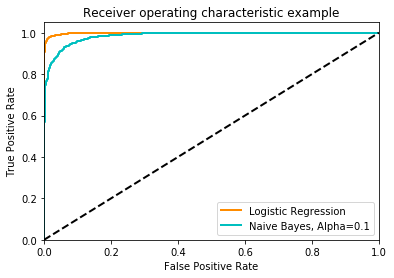

In [414]:
roc_log_reg  = roc_curve(y_test, log_reg.predict_proba(X_test)[:,1], pos_label=1)
roc_na_ba  = roc_curve(y_test, na_ba.predict_proba(X_test)[:,1], pos_label=1)
plt.figure()
lw = 2
plt.plot(roc_log_reg[0], roc_log_reg[1], color='darkorange',
         lw=lw, label='Logistic Regression')

plt.plot(roc_na_ba[0], roc_na_ba[1], color='c',
         lw=lw, label='Naive Bayes, Alpha=0.1')
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [415]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix
[[2316   17]
 [  49 1207]]


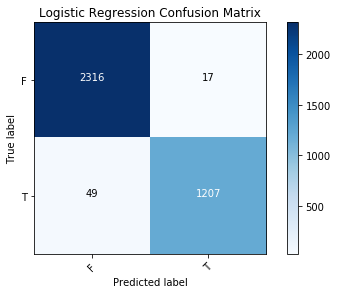

In [416]:
plot_confusion_matrix(log_reg_con_mat,['F','T'], title='Logistic Regression Confusion Matrix')

Confusion matrix
[[2265   68]
 [ 164 1092]]


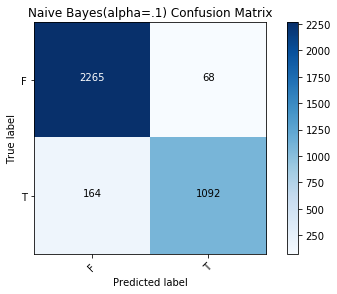

In [417]:
plot_confusion_matrix(na_ba_con_mat,['F','T'], title='Naive Bayes(alpha=.1) Confusion Matrix')

# Feature Exploration

In [419]:
features = vect.get_feature_names()
log_reg_coef = log_reg.coef_.reshape(21793,)

In [420]:
len(features), len(log_reg_coef)

(21793, 21793)

In [421]:
feature_df = pd.DataFrame(features)

In [422]:
feature_df

,0
0,#
1,''
2,*
3,**
4,**want
5,*winner
6,/strong
7,0
8,00
9,000


In [423]:
feature_df['Beta_Coef'] = log_reg_coef
feature_df['Word'] = feature_df[0]

In [424]:
beta_feature_df = feature_df[['Beta_Coef', 'Word']]

In [454]:
sort = beta_feature_df.sort_values('Beta_Coef')

In [455]:
sort

,Beta_Coef,Word
8907,-5.697309,ha
16857,-5.155896,said
20970,-4.715316,wa
19924,-4.675104,trump
16804,-4.112196,s
15021,-3.885832,polic
20055,-3.689592,u
9,-3.655694,000
19637,-3.650920,told
1104,-3.515986,accord


In [473]:
bot_10=list(sort['Beta_Coef'][0:10])
top_10=list(sort['Beta_Coef'][-10:])
bot_top = bot_10 +top_10

In [474]:
bot_10_words = list(sort['Word'][0:10])
top_10_words = list(sort['Word'][-10:])
top_bot_words = bot_10_words + top_10_words

In [ ]:
fig, ax = plt.subplots()
plt.bar(word_counts_df.Source.values,word_counts_df.Average_Word_Count, color ='rby')
ax.set_title("Average Word Count Based on News Source", fontsize = 15)
ax.set_ylabel("Average Word Count", fontsize = 15)
ax.set_xlabel("Source", fontsize = 15)

Text(0.5, 0, 'Word')

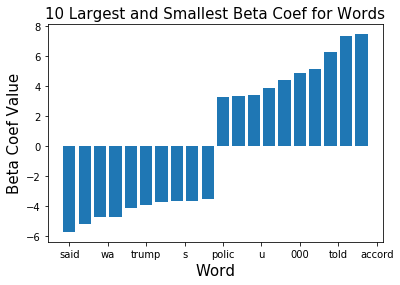

In [490]:
data = x
labels = top_bot_words
fig, ax = plt.subplots()

plt.bar(np.arange(len(data)), data)
#ax.set_xticks(np.arange(len(data)))
ax.set_xticklabels(labels)
ax.set_title("10 Largest and Smallest Beta Coef for Words", fontsize = 15)
ax.set_ylabel("Beta Coef Value", fontsize = 15)
ax.set_xlabel("Word", fontsize = 15)

### Count Vectors

In [94]:
count_vect = CountVectorizer(stop_words='english', tokenizer=tokenize)
X_train_bow = count_vect.fit_transform(docs_train)
X_test_bow = count_vect.transform(docs_test)

/Users/jphooster22/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_

In [553]:
def avg_tfidf_mag(X_train_vect, y_train):
    '''
    Calculates the average magnitude of the TFIDF vector for Satire and News 
    categories
    input: sparse matrix for training
    '''
    row_norms=[]
    for row in X_train:
        row_norms.append(norm(row))
    sums_arr =np.array(row_norms)
    ytr_arr = np.array(y_train)
    tot_sat_art = np.sum(ytr_arr)
    tot_news_art = len(ytr_arr) - tot_sat_art
    Sat_avg_mag = sums_arr[ytr_arr==1].sum()/tot_sat_art
    News_avg_mag = sums_arr[ytr_arr==0].sum()/tot_news_art
    return Sat_avg_mag, News_avg_mag

In [554]:
Satire_mag, News_mag = avg_tfidf_mag(X_train, y_train)

In [555]:
Satire_mag, News_mag

(0.999732905982906, 0.9995727104401082)

Text(0.5, 0, 'Type of Article')

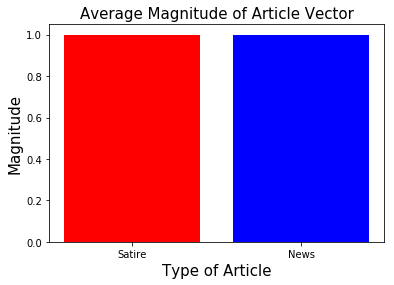

In [561]:
fig, ax = plt.subplots()
plt.bar(['Satire', 'News'],[Satire_mag, News_mag], color ='rby')
ax.set_title("Average Magnitude of Article Vector", fontsize = 15)
ax.set_ylabel("Magnitude", fontsize = 15)
ax.set_xlabel("Type of Article", fontsize = 15)

In [ ]:
fig, ax = plt.subplots()
plt.bar(word_counts_df.Source.values,word_counts_df.Average_Word_Count, color ='rby')
ax.set_title("Average Word Count Based on News Source", fontsize = 15)
ax.set_ylabel("Average Word Count", fontsize = 15)
ax.set_xlabel("Source", fontsize = 15)

In [558]:
word_counts_df.Source.values

array(['Onion', 'CNN', 'Fox'], dtype=object)

### SVD